<a href="https://colab.research.google.com/github/ohallao/MoneyBall-Brasileirao/blob/main/Performance_times_brasileirao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install adjustText

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install soccerdata

In [4]:
import soccerdata as sd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import unidecode
import seaborn as sns
from sklearn.linear_model import LinearRegression
from fuzzywuzzy import process
from adjustText import adjust_text

[01/05/25 16:44:19] INFO     No custom team name replacements found. You can configure these in       ]8;id=156729;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=653638;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#90\90]8;;\
                             /root/soccerdata/config/teamname_replacements.json.                                   

                    INFO     Custom league dict loaded from                                          ]8;id=231637;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py\_config.py]8;;\:]8;id=632517;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_config.py#194\194]8;;\
                             /root/soccerdata/config/league_dict.json.                                             

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
sd.FBref.available_leagues()

['BRA-Serie A',
 'Big 5 European Leagues Combined',
 'ENG-Premier League',
 'ESP-La Liga',
 'FRA-Ligue 1',
 'GER-Bundesliga',
 'INT-European Championship',
 "INT-Women's World Cup",
 'INT-World Cup',
 'ITA-Serie A']

In [6]:
fbref = sd.FBref(leagues="BRA-Serie A", seasons=2024)
print(fbref.__doc__)

[01/05/25 16:44:22] INFO     Saving cached data to /root/soccerdata/data/FBref                       ]8;id=161584;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=132026;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Provides pd.DataFrames from data at http://fbref.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/FBref``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of leagues to include. For efficiently reading data from the Top-5
        European leagues, use "Big 5 European Leagues Combined".
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - "tor": Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
     

In [7]:
team_season_stats = fbref.read_team_season_stats(stat_type="passing")
team_season_stats.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/fbref.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(dfs)
/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


players_used 90s  Total               \
                                                        Cmp    Att  Cmp%   
league      season team                                                    
BRA-Serie A 2425   Ath Paranaense             31  38  12940  16585  78.0   
                   Atl Goianiense             40  38  12615  16234  77.7   
                   Atlético Mineiro           36  38  16633  20059  82.9   
                   Bahia                      30  38  18086  21267  85.0   
                   Botafogo (RJ)              38  38  15519  18939  81.9   

                                                    Short              ...  \
                                    TotDist PrgDist   Cmp   Att  Cmp%  ...   
league      season team                                                ...   
BRA-Serie A 2425   Ath Paranaense    246692   90957  5137  5898  87.1  ...   
                   Atl Goianiense    238675   90421  5086  5892  86.3  ...   
                   Atlético Mineiro  299807  100607  7250  8034  90.2  ...   
                   Bahia             308995  104972  8166  8958  91.2  ...   
                   Botafogo (RJ)     284099  103800  6455  7261  88.9  ...   

                                    Ast   xAG Expected         KP   1/3  PPA  \
                                                    xA A-xAG                   
league      season team                                                        
BRA-Serie A 2425   Ath Paranaense    35  37.8     35.7  -2.8  448  1200  307   
                   Atl Goianiense    16  27.5     30.7 -11.5  405  1259  266   
                   Atlético Mineiro  23  26.0     30.8  -3.0  357  1343  295   
                   Bahia             40  40.5     38.5  -0.5  414  1403  346   
                   Botafogo (RJ)     41  41.1     40.6  -0.1  444  1415  352   

                                    CrsPA  PrgP  \
                                                  
league      season team                           
BRA-Serie A 2425   Ath Paranaense      99  1496   
                   Atl Goianiense      96  1432   
                   Atlético Mineiro    97  1545   
                   Bahia               98  1746   
                   Botafogo (RJ)      105  1703   

                                                                                url  
                                                                                     
league      season team                                                              
BRA-Serie A 2425   Ath Paranaense    /en/squads/2091c619/Athletico-Paranaense-Stats  
                   Atl Goianiense     /en/squads/32d508ca/Atletico-Goianiense-Stats  
                   Atlético Mineiro      /en/squads/422bb734/Atletico-Mineiro-Stats  
                   Bahia                            /en/squads/157b7fee/Bahia-Stats  
                   Botafogo (RJ)              /en/squads/d9fdd9d9/Botafogo-RJ-Stats  

[5 rows x 26 columns]

In [8]:
print(team_season_stats.columns)


MultiIndex([('players_used',        ''),
            (         '90s',        ''),
            (       'Total',     'Cmp'),
            (       'Total',     'Att'),
            (       'Total',    'Cmp%'),
            (       'Total', 'TotDist'),
            (       'Total', 'PrgDist'),
            (       'Short',     'Cmp'),
            (       'Short',     'Att'),
            (       'Short',    'Cmp%'),
            (      'Medium',     'Cmp'),
            (      'Medium',     'Att'),
            (      'Medium',    'Cmp%'),
            (        'Long',     'Cmp'),
            (        'Long',     'Att'),
            (        'Long',    'Cmp%'),
            (         'Ast',        ''),
            (         'xAG',        ''),
            (    'Expected',      'xA'),
            (    'Expected',   'A-xAG'),
            (          'KP',        ''),
            (         '1/3',        ''),
            (         'PPA',        ''),
            (       'CrsPA',        ''),
            (   

In [9]:
sofascore = sd.Sofascore(leagues='BRA-Serie A', seasons='24')
print(sofascore.__doc__)

[01/05/25 16:44:42] INFO     Saving cached data to /root/soccerdata/data/Sofascore                   ]8;id=76874;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=136778;file:///usr/local/lib/python3.10/dist-packages/soccerdata/_common.py#263\263]8;;\

Provides pd.DataFrames from data available at http://www.sofascore.com.

    Data will be downloaded as necessary and cached locally in
    ``~/soccerdata/data/Sofascore``.

    Parameters
    ----------
    leagues : string or iterable, optional
        IDs of Leagues to include.
    seasons : string, int or list, optional
        Seasons to include. Supports multiple formats.
        Examples: '16-17'; 2016; '2016-17'; [14, 15, 16]
    proxy : 'tor' or dict or list(dict) or callable, optional
        Use a proxy to hide your IP address. Valid options are:
            - 'tor': Uses the Tor network. Tor should be running in
              the background on port 9050.
            - dict: A dictionary with the proxy to use. The dict should be
              a mapping of supported protocols to proxy addresses. For example::

                  {
                      'http': 'http://10.10.1.10:3128',
                      'https': 'http://10.10.1.10:1080',
                  }

            - 

In [10]:
league_table = sofascore.read_league_table()
league_table.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


team  MP   W   D  L  GF  GA  GD  Pts
league      season                                               
BRA-Serie A 2425         Botafogo  38  23  10  5  59  29  30   79
            2425        Palmeiras  38  22   7  9  60  33  27   73
            2425         Flamengo  38  20  10  8  61  42  19   70
            2425        Fortaleza  38  19  11  8  53  39  14   68
            2425    Internacional  38  18  11  9  53  36  17   65

In [11]:
def get_market_values(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Verifica se houve erro na requisição
    except requests.exceptions.RequestException as e:
        print(f"Erro na requisição: {e}")
        return pd.DataFrame()  # Retorna DataFrame vazio em caso de erro

    soup = BeautifulSoup(response.content, 'html.parser')

    # Listas para armazenar os dados
    clubes = []
    valores = []

    # Encontrar a tabela com os clubes e valores de mercado
    table = soup.find('table', {'class': 'items'})

    if not table:
        print("Tabela não encontrada.")
        return pd.DataFrame()  # Retorna DataFrame vazio se a tabela não for encontrada

    # Extrair nome do clube e valor de mercado
    rows = table.find_all('tr', {'class': ['odd', 'even']})
    for row in rows:
        try:
            clube = row.find('td', {'class': 'hauptlink'}).text.strip()
            valor = row.find_all('td', {'class': 'rechts'})[1].text.strip()

            # Tratamento do valor de mercado
            valor = valor.lower().replace('€', '').replace('mi', '').replace('.', '').replace(',', '.').strip()
            valor_float = float(valor)  # Escala para milhões

            clubes.append(clube)
            valores.append(valor_float)
        except (AttributeError, IndexError, ValueError) as e:
            print(f"Erro ao processar a linha: {e}")
            continue  # Ignora a linha em caso de erro e continua o scraping

        # Adicionar delay para evitar bloqueios (entre 3 e 6 segundos)
        time.sleep(random.uniform(3, 6))

    # Retornar os dados como DataFrame
    df = pd.DataFrame({'Clube': clubes, 'Valor de Mercado (€)': valores})
    return df

# URL da página da Série A no Transfermarkt
url = 'https://www.transfermarkt.com.br/campeonato-brasileiro-serie-a/startseite/wettbewerb/BRA1'

# Executar a função e exibir os dados
df_clubes = get_market_values(url)
print(df_clubes)


               Clube  Valor de Mercado (€)
0       SE Palmeiras                236.68
1        CR Flamengo                216.95
2        Botafogo FR                162.30
3     SC Corinthians                108.20
4       São Paulo FC                 97.65
5   SC Internacional                 90.55
6        Cruzeiro EC                 89.35
7   Atlético Mineiro                 86.70
8      RB Bragantino                 81.20
9   CR Vasco da Gama                 79.70
10       Grêmio FBPA                 78.30
11     Fluminense FC                 77.45
12          EC Bahia                 76.95
13      Fortaleza EC                 54.45
14         Santos FC                 53.10
15        EC Vitória                 24.33
16          Ceará SC                 19.55
17      EC Juventude                 13.33
18      Sport Recife                 12.85
19       Mirassol FC                  8.68


In [12]:
# Verificar os Nomes dos Clubes
df_teams = league_table
print("Clubes no Sofascore:")
print(df_teams['team'].unique())

print("\nClubes no Transfermarkt:")
print(df_clubes['Clube'].unique())

Clubes no Sofascore:
['Botafogo' 'Palmeiras' 'Flamengo' 'Fortaleza' 'Internacional' 'São Paulo'
 'Corinthians' 'Bahia' 'Cruzeiro' 'Vasco da Gama' 'Vitória'
 'Atlético Mineiro' 'Fluminense' 'Grêmio' 'Juventude'
 'Red Bull Bragantino' 'Athletico' 'Criciúma' 'Atlético Goianiense'
 'Cuiabá']

Clubes no Transfermarkt:
['SE Palmeiras' 'CR Flamengo' 'Botafogo FR' 'SC Corinthians'
 'São Paulo FC' 'SC Internacional' 'Cruzeiro EC' 'Atlético Mineiro'
 'RB Bragantino' 'CR Vasco da Gama' 'Grêmio FBPA' 'Fluminense FC'
 'EC Bahia' 'Fortaleza EC' 'Santos FC' 'EC Vitória' 'Ceará SC'
 'EC Juventude' 'Sport Recife' 'Mirassol FC']


In [13]:
# Função para encontrar correspondências aproximadas
def padronizar_nome(nome, lista_nomes):
    nome_padronizado, score = process.extractOne(nome, lista_nomes)
    if score >= 80:  # Considera como match se a similaridade for alta
        return nome_padronizado
    return None

# Aplicar fuzzy matching para padronizar nomes
df_teams['team_mapeado_fuzzy'] = df_teams['team'].apply(
    lambda x: padronizar_nome(x, df_clubes['Clube'].unique())
).fillna(df_teams['team'])

# Verificar se a padronização ocorreu corretamente
print("\nClubes mapeados:")
print(df_teams[['team', 'team_mapeado_fuzzy']].head())

# Tentar unir os DataFrames
df = pd.merge(df_teams, df_clubes, left_on='team_mapeado_fuzzy', right_on='Clube', how='inner')

# Verificar o DataFrame resultante
print("\nPrimeiras linhas do DataFrame após o merge:")
print(df.head())

# Garantir que as colunas necessárias existem antes de calcular a eficiência
if 'Pts' in df.columns and 'Valor de Mercado (€)' in df.columns:
    df['eficiencia'] = df['Pts'] / df['Valor de Mercado (€)']
else:
    print("\nErro: Colunas necessárias para calcular a eficiência não encontradas.")

# Exibir o DataFrame final
print("\nDados Integrados:")
print(df[['team_mapeado_fuzzy', 'Pts', 'Valor de Mercado (€)', 'eficiencia']])

# Ordenar por eficiência em ordem decrescente, se disponível
if 'eficiencia' in df.columns:
    df = df.sort_values(by='eficiencia', ascending=False)
    print("\nDados Ordenados por Eficiência:")
    print(df[['team_mapeado_fuzzy', 'Pts', 'Valor de Mercado (€)', 'eficiencia']])
else:
    print("\nEficiência não pode ser calculada devido a colunas ausentes.")



Clubes mapeados:
                             team team_mapeado_fuzzy
league      season                                  
BRA-Serie A 2425         Botafogo        Botafogo FR
            2425        Palmeiras       SE Palmeiras
            2425         Flamengo        CR Flamengo
            2425        Fortaleza       Fortaleza EC
            2425    Internacional   SC Internacional

Primeiras linhas do DataFrame após o merge:
            team  MP   W   D  L  GF  GA  GD  Pts team_mapeado_fuzzy  \
0       Botafogo  38  23  10  5  59  29  30   79        Botafogo FR   
1      Palmeiras  38  22   7  9  60  33  27   73       SE Palmeiras   
2       Flamengo  38  20  10  8  61  42  19   70        CR Flamengo   
3      Fortaleza  38  19  11  8  53  39  14   68       Fortaleza EC   
4  Internacional  38  18  11  9  53  36  17   65   SC Internacional   

              Clube  Valor de Mercado (€)  
0       Botafogo FR                162.30  
1      SE Palmeiras                236.68  
2      

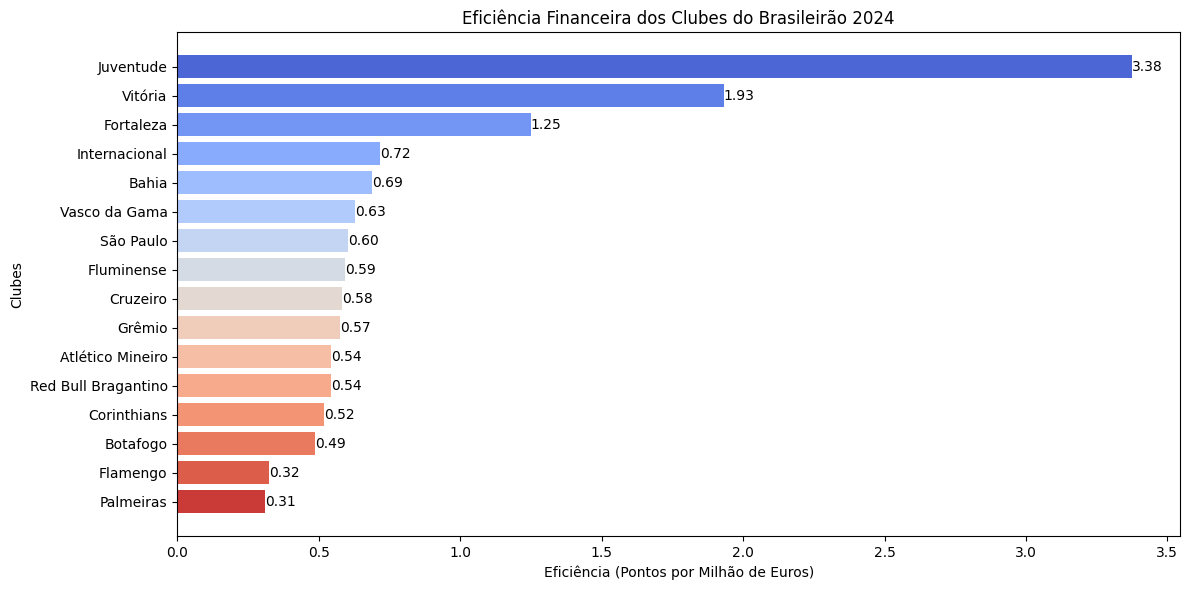

In [14]:
# Criar uma paleta de cores baseada na eficiência
cores = sns.color_palette("coolwarm", len(df))

# Gerar o gráfico com cores variadas
plt.figure(figsize=(12, 6))
bars = plt.barh(df['team'], df['eficiencia'], color=cores)
plt.barh(df['team'], df['eficiencia'], color=cores)
plt.xlabel('Eficiência (Pontos por Milhão de Euros)')
plt.ylabel('Clubes')
plt.title('Eficiência Financeira dos Clubes do Brasileirão 2024')

# Adicionar anotações em cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', va='center')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [15]:
correlacao = df[['Pts', 'Valor de Mercado (€)']].corr()
print("Correlação entre Pontos e Valor de Mercado:")
print(correlacao)


Correlação entre Pontos e Valor de Mercado:
                           Pts  Valor de Mercado (€)
Pts                   1.000000              0.721988
Valor de Mercado (€)  0.721988              1.000000


Correlação positiva (0.721):
Isso sugere que, em geral, clubes com maior valor de mercado tendem a conquistar mais pontos, mas essa relação não é perfeita.

Correlação moderada:
Embora exista uma tendência positiva, outros fatores além do valor de mercado influenciam os pontos conquistados (como a gestão, técnico, planejamento e desempenho dos jogadores em campo).

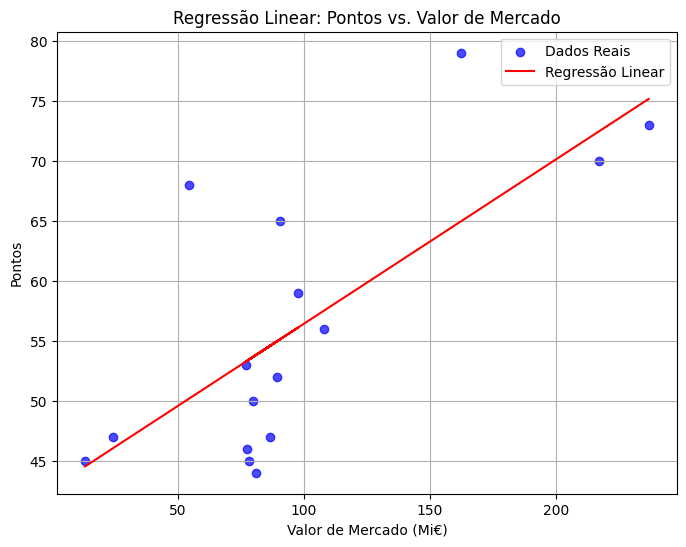

Coeficiente da Regressão: 0.14
Intercepto: 42.70


In [16]:
# Preparar os dados
X = df[['Valor de Mercado (€)']].values
y = df['Pts'].values

# Ajustar o modelo de regressão linear
modelo = LinearRegression()
modelo.fit(X, y)

# Fazer previsões
y_pred = modelo.predict(X)

# Plotar os resultados
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.7, label='Dados Reais')
plt.plot(X, y_pred, color='red', label='Regressão Linear')
plt.title('Regressão Linear: Pontos vs. Valor de Mercado')
plt.xlabel('Valor de Mercado (Mi€)')
plt.ylabel('Pontos')
plt.legend()
plt.grid(True)
plt.show()

print(f"Coeficiente da Regressão: {modelo.coef_[0]:.2f}")
print(f"Intercepto: {modelo.intercept_:.2f}")


In [17]:
r2 = modelo.score(X, y)
print(f"R²: {r2:.2f}")

R²: 0.52


O valor de R² = 0.52 indica que o modelo de regressão linear explica 52% da variação nos pontos dos clubes com base no valor de mercado. Isso sugere que o valor de mercado tem alguma influência no desempenho dos clubes, mas 48% da variação nos pontos é explicada por outros fatores.

In [18]:
 #Adicionar Variáveis Explicativas que possam melhorar o modelo

# Selecionar as colunas relevantes do league_table
df_teams = league_table[['team', 'GF', 'GA', 'Pts']].copy()

# Renomear as colunas para facilitar a leitura
df_teams = df_teams.rename(columns={
    'GF': 'gols_marcados',
    'GA': 'gols_sofridos',
    'Pts': 'pontos'
})

# Adicionar nova variável explicativa: saldo de gols
df_teams['saldo_gols'] = df_teams['gols_marcados'] - df_teams['gols_sofridos']

# Exibir uma amostra dos dados com as variáveis explicativas
print("\nAmostra dos Dados:")
print(df_teams.head())



Amostra dos Dados:
                             team  gols_marcados  gols_sofridos  pontos  \
league      season                                                        
BRA-Serie A 2425         Botafogo             59             29      79   
            2425        Palmeiras             60             33      73   
            2425         Flamengo             61             42      70   
            2425        Fortaleza             53             39      68   
            2425    Internacional             53             36      65   

                    saldo_gols  
league      season              
BRA-Serie A 2425            30  
            2425            27  
            2425            19  
            2425            14  
            2425            17  


In [19]:
#Adicionar Variáveis Explicativas que possam melhorar o modelo
# Selecionar as colunas relevantes do league_table
df_teams = league_table[['team', 'GF', 'GA', 'Pts']].copy()

# Renomear as colunas para facilitar a leitura
df_teams = df_teams.rename(columns={'GF': 'gols_marcados', 'GA': 'gols_sofridos', 'Pts': 'pontos'})

# Exibir uma amostra dos dados
print(df_teams.head())


                             team  gols_marcados  gols_sofridos  pontos
league      season                                                     
BRA-Serie A 2425         Botafogo             59             29      79
            2425        Palmeiras             60             33      73
            2425         Flamengo             61             42      70
            2425        Fortaleza             53             39      68
            2425    Internacional             53             36      65


In [20]:
# Clubes não combinados do Sofascore
clubes_nao_mapeados_sofascore = df_teams[~df_teams['team'].isin(df['team'])]
print("\nClubes do Sofascore não combinados:")
print(clubes_nao_mapeados_sofascore['team'].unique())

# Clubes não combinados do Transfermarkt
clubes_nao_mapeados_transfermarkt = df_clubes[~df_clubes['Clube'].isin(df['Clube'])]
print("\nClubes do Transfermarkt não combinados:")
print(clubes_nao_mapeados_transfermarkt['Clube'].unique())



Clubes do Sofascore não combinados:
['Athletico' 'Criciúma' 'Atlético Goianiense' 'Cuiabá']

Clubes do Transfermarkt não combinados:
['Santos FC' 'Ceará SC' 'Sport Recife' 'Mirassol FC']


In [21]:
# Função para encontrar correspondências aproximadas
def padronizar_nome(nome, lista_nomes):
    nome_padronizado, score = process.extractOne(nome, lista_nomes)
    if score >= 80:  # Considerar correspondências com score >= 80
        return nome_padronizado
    return None

# Aplicar fuzzy matching aos nomes dos clubes do Sofascore
df_teams['team_padronizado'] = df_teams['team'].apply(
    lambda x: padronizar_nome(x, df_clubes['Clube'].unique())
).fillna(df_teams['team'])

# Realizar a união dos DataFrames com nomes padronizados
df = pd.merge(
    df_teams,
    df_clubes,
    left_on='team_padronizado',
    right_on='Clube',
    how='inner'
)

# Verificar o DataFrame após a união
print("\nTimes combinados corretamente:")
print(df[['team_padronizado', 'pontos', 'Valor de Mercado (€)']])

# Definir as variáveis independentes e a variável dependente
X2 = df[['Valor de Mercado (€)', 'gols_marcados', 'gols_sofridos']]
y2 = df['pontos']

# Treinar o modelo de regressão linear
modelo2 = LinearRegression()
modelo2.fit(X2, y2)

# Fazer previsões
df['pontos_previstos'] = modelo2.predict(X2)

# Avaliar o modelo
r2 = modelo2.score(X2, y2)
print(f"\nR²: {r2:.2f}")
# Exibir os coeficientes da regressão
print(f"Coeficientes: {modelo2.coef_}")
print(f"Intercepto: {modelo2.intercept_}")
# Exibir os times com pontos reais e previstos
print("\nTimes Avaliados e Pontos Previstos:")
print(df[['team_padronizado', 'pontos', 'pontos_previstos']])


Times combinados corretamente:
    team_padronizado  pontos  Valor de Mercado (€)
0        Botafogo FR      79                162.30
1       SE Palmeiras      73                236.68
2        CR Flamengo      70                216.95
3       Fortaleza EC      68                 54.45
4   SC Internacional      65                 90.55
5       São Paulo FC      59                 97.65
6     SC Corinthians      56                108.20
7           EC Bahia      53                 76.95
8        Cruzeiro EC      52                 89.35
9   CR Vasco da Gama      50                 79.70
10        EC Vitória      47                 24.33
11  Atlético Mineiro      47                 86.70
12     Fluminense FC      46                 77.45
13       Grêmio FBPA      45                 78.30
14      EC Juventude      45                 13.33
15     RB Bragantino      44                 81.20

R²: 0.93
Coeficientes: [-0.00424953  0.93908744 -0.71451288]
Intercepto: 42.226616752995454

Times A

## Coeficientes:
### Valor de Mercado (€):
Coeficiente: -0.0042
O coeficiente negativo sugere que, em média, o aumento no valor de mercado tem um impacto pequeno e negativo nos pontos. Pode indicar que valor de mercado sozinho não garante sucesso em campo.

### Gols Marcados:
Coeficiente: 0.939
Cada gol marcado adiciona aproximadamente 1 ponto. Isso confirma a importância de um ataque eficiente para o desempenho.

### Gols Sofridos:
Coeficiente: -0.714
Cada gol sofrido reduz os pontos em cerca de 0.71. Esse coeficiente reforça a importância de uma defesa sólida.

### Intercepto: 42.22

Este valor representa o número de pontos previstos para um time com todas as variáveis independentes iguais a zero (ou seja, no ponto de origem do modelo). Embora não tenha um significado prático direto, ele é necessário para ajustar a linha de regressão.

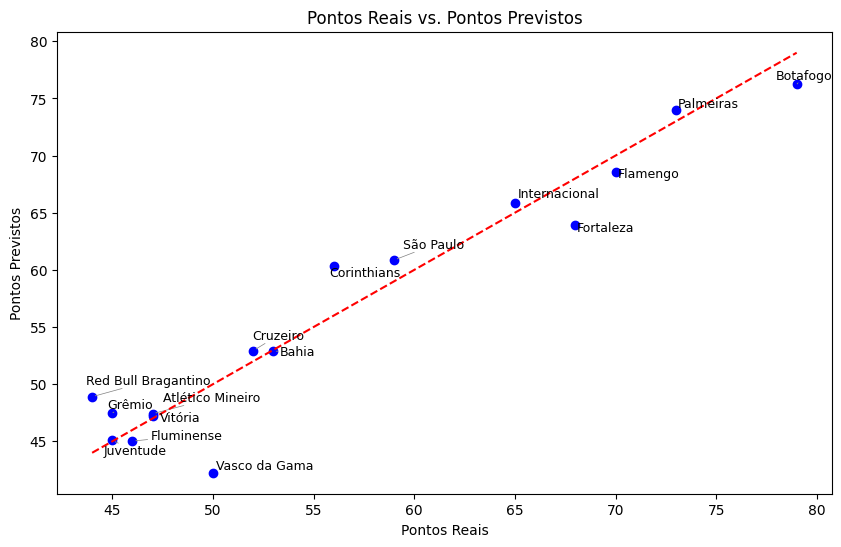

In [22]:
# Criar o scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['pontos'], df['pontos_previstos'], color='blue')

# Adicionar uma linha de referência para comparação 1:1
plt.plot(
    [df['pontos'].min(), df['pontos'].max()],
    [df['pontos'].min(), df['pontos'].max()],
    'r--'
)

# Adicionar os nomes dos times usando adjust_text para evitar sobreposição
texts = []
for i in range(df.shape[0]):
    texts.append(
        plt.text(
            df['pontos'].iloc[i],
            df['pontos_previstos'].iloc[i],
            df['team'].iloc[i],
            fontsize=9
        )
    )

# Ajustar os textos para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Configurar rótulos e título
plt.xlabel('Pontos Reais')
plt.ylabel('Pontos Previstos')
plt.title('Pontos Reais vs. Pontos Previstos')

# Exibir o gráfico
plt.show()

In [23]:
# Calcular custo por gol e custo por ponto
df['Custo por Gol (€)'] = df['Valor de Mercado (€)'] / df['gols_marcados']
df['Custo por Ponto (€)'] = df['Valor de Mercado (€)'] / df['pontos']

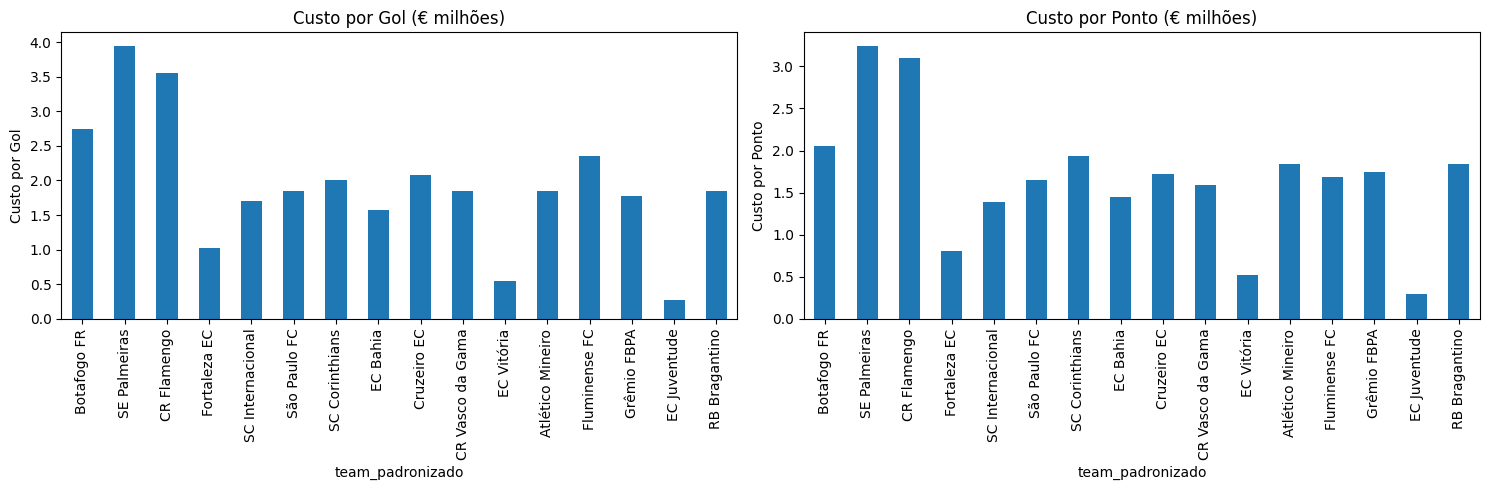

,team_padronizado,Custo por Gol (€),Custo por Ponto (€)
0,Botafogo FR,2.750847,2.054430
1,SE Palmeiras,3.944667,3.242192
2,CR Flamengo,3.556557,3.099286
3,Fortaleza EC,1.027358,0.800735
4,SC Internacional,1.708491,1.393077
5,São Paulo FC,1.842453,1.655085
6,SC Corinthians,2.003704,1.932143
7,EC Bahia,1.570408,1.451887
8,Cruzeiro EC,2.077907,1.718269
9,CR Vasco da Gama,1.853488,1.594000


In [24]:
# Gráficos para comparar os custos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de custo por gol
df.plot(kind='bar', x='team_padronizado', y='Custo por Gol (€)', ax=axes[0], legend=False)
axes[0].set_title('Custo por Gol (€ milhões)')
axes[0].set_ylabel('Custo por Gol')

# Gráfico de custo por ponto
df.plot(kind='bar', x='team_padronizado', y='Custo por Ponto (€)', ax=axes[1], legend=False)
axes[1].set_title('Custo por Ponto (€ milhões)')
axes[1].set_ylabel('Custo por Ponto')

plt.tight_layout()
plt.show()

# Exibir os dados calculados
df[['team_padronizado', 'Custo por Gol (€)', 'Custo por Ponto (€)']]



*  Custo por Gol mais baixo:
#####   EC Juventude (€0.54M) e Criciúma EC (€0.58M) são extremamente eficientes em marcar gols com menor custo.
    
*  Custo por Ponto mais baixo:
##### Fortaleza EC (€0.81M) tem o menor custo por ponto, destacando uma relação excelente entre investimento e pontuação.

*  Custo por Gol mais alto:
##### CR Flamengo (€4.71M) e SE Palmeiras (€4.11M) gastam mais para cada gol marcado, indicando uma ineficiência relativa.

*  Custo por Ponto mais alto:
##### CR Flamengo (€4.15M) e SE Palmeiras (€3.49M) também apresentam os maiores custos por ponto, sugerindo que o alto valor de mercado não está sendo traduzido em desempenho ideal no campo.



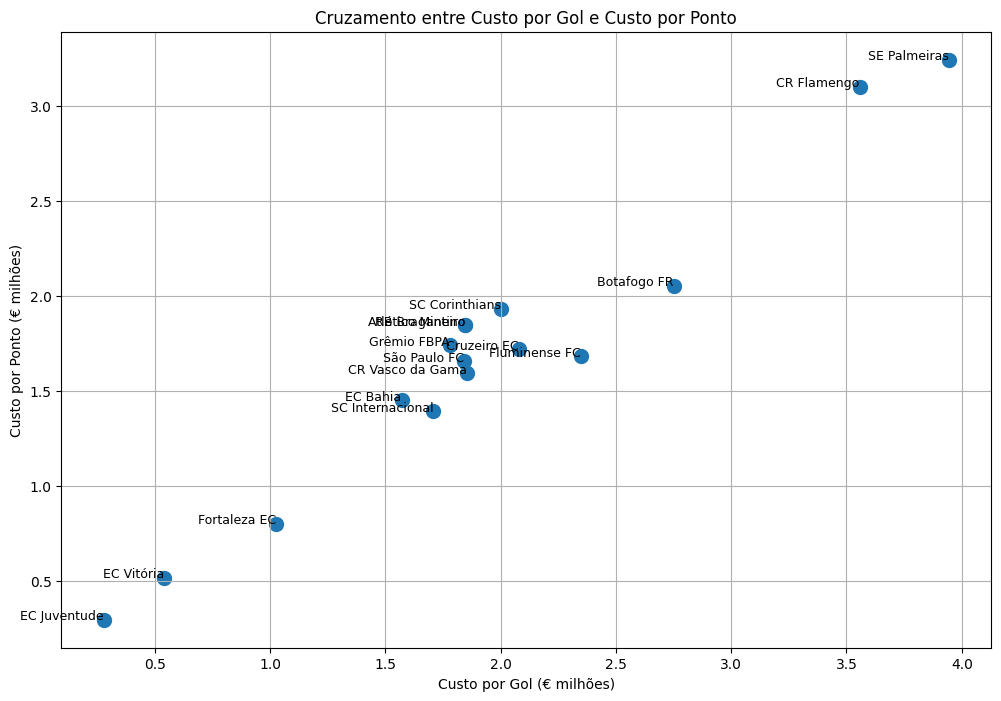

In [25]:
# Criar um gráfico de dispersão cruzando Custo por Gol e Custo por Ponto
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Custo por Gol (€)'], df['Custo por Ponto (€)'], s=100)

# Adicionar rótulos aos pontos
for i, team in enumerate(df['team_padronizado']):
    plt.text(df['Custo por Gol (€)'][i], df['Custo por Ponto (€)'][i], team, fontsize=9, ha='right')

# Adicionar título e rótulos
plt.title('Cruzamento entre Custo por Gol e Custo por Ponto')
plt.xlabel('Custo por Gol (€ milhões)')
plt.ylabel('Custo por Ponto (€ milhões)')

# Exibir o gráfico
plt.grid(True)
plt.show()



1.   Eficiência Máxima:
#### **Fortaleza EC**, **EC Juventude** e **Criciúma EC** mantêm a posição de maior eficiência, com baixo custo por ponto e por gol.
2.   Ineficiência Relativa:
#### **CR Flamengo** e **SE Palmeiras** continuam no topo da ineficiência, apresentando os maiores custos tanto por gol quanto por ponto.
3.   Clubes Intermediários:
#### **Atlético Mineiro**, **Grêmio** e **Fluminense** têm custos mais equilibrados, mas ainda estão distantes dos mais eficientes.
#### **Corinthians** apresenta um custo por ponto elevado, sugerindo uma dificuldade em transformar investimento em desempenho esportivo.
4.   Clubes com Bom Equilíbrio:
#### **Athletico Paranaense**, **SC Internacional** e **EC Bahia** se destacam por um custo relativamente baixo, indicando um bom aproveitamento financeiro.





In [26]:
team_season_std_stats = fbref.read_team_season_stats(stat_type="standard")
team_season_std_stats.head()

/usr/local/lib/python3.10/dist-packages/soccerdata/fbref.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(dfs)
/usr/local/lib/python3.10/dist-packages/soccerdata/_common.py:145: UserWarning: Season id "2021" is ambiguous: interpreting as "20-21"
  warnings.warn(msg, stacklevel=1)


players_used   Age  Poss Playing Time  \
                                                                       MP   
league      season team                                                     
BRA-Serie A 2425   Ath Paranaense             31  26.2  46.9           38   
                   Atl Goianiense             40  26.5  47.4           38   
                   Atlético Mineiro           36  28.1  57.2           38   
                   Bahia                      30  27.7  55.8           38   
                   Botafogo (RJ)              38  27.9  53.8           38   

                                                     Performance          ...  \
                                    Starts   Min 90s         Gls Ast G+A  ...   
league      season team                                                   ...   
BRA-Serie A 2425   Ath Paranaense      418  3420  38          39  35  74  ...   
                   Atl Goianiense      418  3420  38          28  16  44  ...   
                   Atlético Mineiro    418  3420  38          47  23  70  ...   
                   Bahia               418  3420  38          49  40  89  ...   
                   Botafogo (RJ)       418  3420  38          58  41  99  ...   

                                    Per 90 Minutes                           \
                                               Ast   G+A  G-PK G+A-PK    xG   
league      season team                                                       
BRA-Serie A 2425   Ath Paranaense             0.92  1.95   1.0   1.92  1.24   
                   Atl Goianiense             0.42  1.16  0.66   1.08  1.07   
                   Atlético Mineiro           0.61  1.84  0.95   1.55  1.21   
                   Bahia                      1.05  2.34  1.24   2.29  1.35   
                   Botafogo (RJ)              1.08  2.61  1.42    2.5  1.51   

                                                                 \
                                      xAG xG+xAG  npxG npxG+xAG   
league      season team                                           
BRA-Serie A 2425   Ath Paranaense    0.99   2.23   1.2     2.19   
                   Atl Goianiense    0.72   1.79  0.96     1.68   
                   Atlético Mineiro  0.68    1.9  0.94     1.63   
                   Bahia             1.07   2.42  1.31     2.38   
                   Botafogo (RJ)     1.08   2.59  1.39     2.47   

                                                                                url  
                                                                                     
league      season team                                                              
BRA-Serie A 2425   Ath Paranaense    /en/squads/2091c619/Athletico-Paranaense-Stats  
                   Atl Goianiense     /en/squads/32d508ca/Atletico-Goianiense-Stats  
                   Atlético Mineiro      /en/squads/422bb734/Atletico-Mineiro-Stats  
                   Bahia                            /en/squads/157b7fee/Bahia-Stats  
                   Botafogo (RJ)              /en/squads/d9fdd9d9/Botafogo-RJ-Stats  

[5 rows x 32 columns]

In [27]:
# Selecionar colunas específicas do MultiIndex
xg_xag_df = team_season_std_stats[[('Performance','Gls'),
                                   ('Performance','Ast'),
                                   ('Expected','xG'),
                                   ('Expected','xAG')]]

# Renomear as colunas para facilitar o uso
xg_xag_df.columns = ['Gols','Assistencias','xG','xAG']
# Resetar o índice para mover liga e temporada para colunas separadas
xg_xag_df = xg_xag_df.reset_index(level=['league', 'season'], drop=True)
print(xg_xag_df)


                     Gols  Assistencias    xG   xAG
team                                               
Ath Paranaense         39            35  47.0  37.8
Atl Goianiense         28            16  40.6  27.5
Atlético Mineiro       47            23  46.0  26.0
Bahia                  49            40  51.3  40.5
Botafogo (RJ)          58            41  57.3  41.1
Corinthians            54            36  49.1  34.0
Criciúma               42            27  37.4  26.9
Cruzeiro               43            30  40.0  25.8
Cuiabá                 28            16  31.9  20.9
Flamengo               60            42  56.4  38.9
Fluminense             31            26  37.6  27.4
Fortaleza              51            38  43.6  31.6
Grêmio                 42            28  43.4  29.9
Internacional          52            33  58.4  40.1
Juventude              48            40  42.9  33.6
Palmeiras              58            35  67.0  47.4
Red Bull Bragantino    44            32  39.4  28.6
São Paulo   

                  Gols    xG  Gls_xG_diff  Assistencias   xAG  Ast_xAG_diff
team                                                                       
Ath Paranaense      39  47.0         -8.0            35  37.8          -2.8
Atl Goianiense      28  40.6        -12.6            16  27.5         -11.5
Atlético Mineiro    47  46.0          1.0            23  26.0          -3.0
Bahia               49  51.3         -2.3            40  40.5          -0.5
Botafogo (RJ)       58  57.3          0.7            41  41.1          -0.1


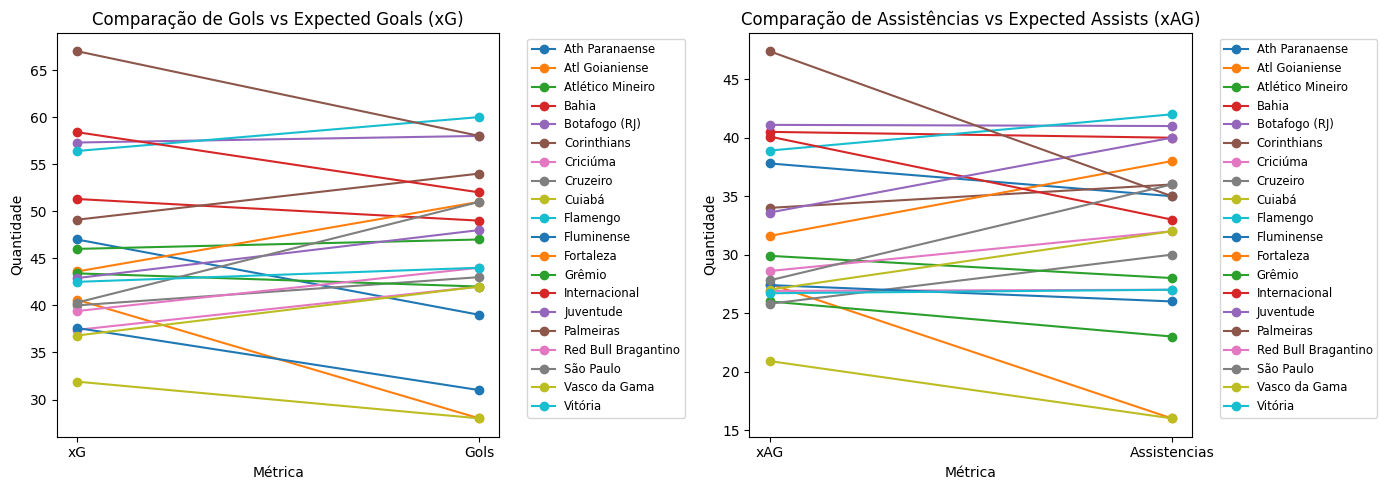

In [28]:
# Calcular as diferenças entre valores reais e esperados
xg_xag_df['Gls_xG_diff'] = xg_xag_df['Gols'] - xg_xag_df['xG']
xg_xag_df['Ast_xAG_diff'] = xg_xag_df['Assistencias'] - xg_xag_df['xAG']

# Exibir uma amostra do DataFrame para conferência
print(xg_xag_df[['Gols', 'xG', 'Gls_xG_diff', 'Assistencias', 'xAG', 'Ast_xAG_diff']].head())

# Criar gráficos para comparação
plt.figure(figsize=(14, 5))

# Subplot 1: Gols vs xG
plt.subplot(1, 2, 1)
for i, row in xg_xag_df.iterrows():
    plt.plot(['xG', 'Gols'], [row['xG'], row['Gols']], marker='o', label=f'{i}')

plt.title('Comparação de Gols vs Expected Goals (xG)')
plt.xlabel('Métrica')
plt.ylabel('Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Adicionar legenda externa

# Subplot 2: Assistências vs xAG
plt.subplot(1, 2, 2)
for i, row in xg_xag_df.iterrows():
    plt.plot(['xAG', 'Assistencias'], [row['xAG'], row['Assistencias']], marker='o', label=f'{i}')

plt.title('Comparação de Assistências vs Expected Assists (xAG)')
plt.xlabel('Métrica')
plt.ylabel('Quantidade')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Adicionar legenda externa

plt.tight_layout()
plt.show()

#Interpretação dos Resultados
- Gols e Assistências Acima das Expectativas: Se a diferença for positiva, o time está superando as expectativas.

- Gols e Assistências Abaixo das Expectativas: Se a diferença for negativa, o desempenho está abaixo do esperado.

#Eficiência Ofensiva (Overperformance / Underperformance)

In [29]:
# Calcular eficiência ofensiva: Gols / xG
xg_xag_df['Eficiencia_Ofensiva'] = xg_xag_df['Gols'] / xg_xag_df['xG']

# Exibir a eficiência ofensiva
print(xg_xag_df[['Gols', 'xG', 'Eficiencia_Ofensiva']])


                     Gols    xG  Eficiencia_Ofensiva
team                                                
Ath Paranaense         39  47.0             0.829787
Atl Goianiense         28  40.6             0.689655
Atlético Mineiro       47  46.0             1.021739
Bahia                  49  51.3             0.955166
Botafogo (RJ)          58  57.3             1.012216
Corinthians            54  49.1             1.099796
Criciúma               42  37.4             1.122995
Cruzeiro               43  40.0                1.075
Cuiabá                 28  31.9             0.877743
Flamengo               60  56.4              1.06383
Fluminense             31  37.6             0.824468
Fortaleza              51  43.6             1.169725
Grêmio                 42  43.4             0.967742
Internacional          52  58.4             0.890411
Juventude              48  42.9             1.118881
Palmeiras              58  67.0             0.865672
Red Bull Bragantino    44  39.4             1.

In [30]:
# Calcular eficiência de assistências: Assistências / xAG
xg_xag_df['Eficiencia_Assistencias'] = xg_xag_df['Assistencias'] / xg_xag_df['xAG']

# Exibir a eficiência de assistências
print(xg_xag_df[['Assistencias', 'xAG', 'Eficiencia_Assistencias']])

                     Assistencias   xAG  Eficiencia_Assistencias
team                                                            
Ath Paranaense                 35  37.8                 0.925926
Atl Goianiense                 16  27.5                 0.581818
Atlético Mineiro               23  26.0                 0.884615
Bahia                          40  40.5                 0.987654
Botafogo (RJ)                  41  41.1                 0.997567
Corinthians                    36  34.0                 1.058824
Criciúma                       27  26.9                 1.003717
Cruzeiro                       30  25.8                 1.162791
Cuiabá                         16  20.9                  0.76555
Flamengo                       42  38.9                 1.079692
Fluminense                     26  27.4                 0.948905
Fortaleza                      38  31.6                 1.202532
Grêmio                         28  29.9                 0.936455
Internacional            

###### Interpretação:
###### Valor > 1: Overperformance (gols além do esperado).
###### Valor < 1: Underperformance (gols abaixo do esperado).

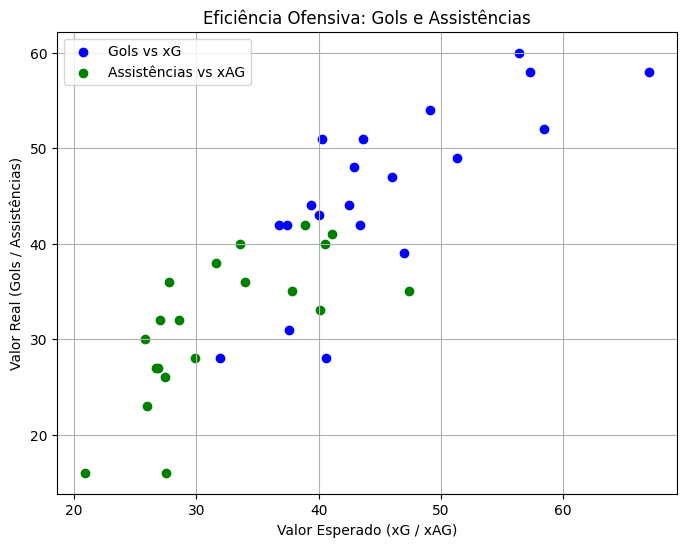

In [31]:
plt.figure(figsize=(8, 6))

# Scatter plot para eficiência ofensiva
plt.scatter(xg_xag_df['xG'], xg_xag_df['Gols'], color='blue', label='Gols vs xG')
plt.scatter(xg_xag_df['xAG'], xg_xag_df['Assistencias'], color='green', label='Assistências vs xAG')

plt.xlabel('Valor Esperado (xG / xAG)')
plt.ylabel('Valor Real (Gols / Assistências)')
plt.title('Eficiência Ofensiva: Gols e Assistências')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
# Diferença percentual para Gols
xg_xag_df['Diff_Percent_Gols'] = ((xg_xag_df['Gols'] - xg_xag_df['xG']) / xg_xag_df['xG']) * 100

# Diferença percentual para Assistências
xg_xag_df['Diff_Percent_Assist'] = ((xg_xag_df['Assistencias'] - xg_xag_df['xAG']) / xg_xag_df['xAG']) * 100

# Exibir as diferenças percentuais
print(xg_xag_df[['Diff_Percent_Gols', 'Diff_Percent_Assist']])


                     Diff_Percent_Gols  Diff_Percent_Assist
team                                                       
Ath Paranaense              -17.021277            -7.407407
Atl Goianiense              -31.034483           -41.818182
Atlético Mineiro              2.173913           -11.538462
Bahia                        -4.483431            -1.234568
Botafogo (RJ)                  1.22164            -0.243309
Corinthians                   9.979633             5.882353
Criciúma                     12.299465             0.371747
Cruzeiro                           7.5             16.27907
Cuiabá                      -12.225705           -23.444976
Flamengo                      6.382979             7.969152
Fluminense                  -17.553191            -5.109489
Fortaleza                    16.972477            20.253165
Grêmio                       -3.225806            -6.354515
Internacional               -10.958904           -17.705736
Juventude                    11.888112  

Interpretação:
- Valores positivos indicam overperformance.
- Valores negativos indicam underperformance.

In [33]:
# Ranking por eficiência ofensiva
ranking_ofensivo = xg_xag_df.sort_values('Eficiencia_Ofensiva', ascending=False)
print("Ranking por Eficiência Ofensiva:")
print(ranking_ofensivo[['Eficiencia_Ofensiva']])

# Ranking por eficiência de assistências
ranking_assistencias = xg_xag_df.sort_values('Eficiencia_Assistencias', ascending=False)
print("\nRanking por Eficiência de Assistências:")
print(ranking_assistencias[['Eficiencia_Assistencias']])


correlacao_gols = xg_xag_df[['Gols', 'xG']].corr().iloc[0, 1]
correlacao_assist = xg_xag_df[['Assistencias', 'xAG']].corr().iloc[0, 1]

print(f"Correlação entre Gols e xG: {correlacao_gols:.2f}")
print(f"Correlação entre Assistências e xAG: {correlacao_assist:.2f}")


Ranking por Eficiência Ofensiva:
                     Eficiencia_Ofensiva
team                                    
São Paulo                       1.265509
Fortaleza                       1.169725
Vasco da Gama                   1.141304
Criciúma                        1.122995
Juventude                       1.118881
Red Bull Bragantino             1.116751
Corinthians                     1.099796
Cruzeiro                           1.075
Flamengo                         1.06383
Vitória                         1.035294
Atlético Mineiro                1.021739
Botafogo (RJ)                   1.012216
Grêmio                          0.967742
Bahia                           0.955166
Internacional                   0.890411
Cuiabá                          0.877743
Palmeiras                       0.865672
Ath Paranaense                  0.829787
Fluminense                      0.824468
Atl Goianiense                  0.689655

Ranking por Eficiência de Assistências:
                     Efi

# Correlação entre Gols e xG: 0.76

- Isso indica uma forte correlação positiva, ou seja, os valores de xG conseguem explicar razoavelmente bem o número de gols marcados pelos times.
- No entanto, o valor não é perfeito (1.0), sugerindo que alguns times estão superando ou ficando abaixo do esperado. Isso pode indicar:
  - Eficiência nas finalizações: Times que convertem mais do que o esperado.
  - Desempenho inferior: Times que desperdiçam chances claras de gol.

# Correlação entre Assistências e xAG: 0.70

- Também é uma correlação positiva forte, mas ligeiramente menor do que a de gols e xG. Isso pode indicar:
  - A criação de chances é relativamente consistente com o número de assistências, mas existem variações.
  - Jogadas individuais ou outros fatores podem estar resultando em gols sem assistência direta.

In [34]:
# Identificar outliers em Gols vs xG
outliers_gols = xg_xag_df[xg_xag_df['Gls_xG_diff'].abs() > 5]
print("Times com desempenho fora da curva em Gols:")
print(outliers_gols[['Gols', 'xG', 'Gls_xG_diff']])

# Identificar outliers em Assistências vs xAG
outliers_assists = xg_xag_df[xg_xag_df['Ast_xAG_diff'].abs() > 5]
print("\nTimes com desempenho fora da curva em Assistências:")
print(outliers_assists[['Assistencias', 'xAG', 'Ast_xAG_diff']])

Times com desempenho fora da curva em Gols:
                Gols    xG  Gls_xG_diff
team                                   
Ath Paranaense    39  47.0         -8.0
Atl Goianiense    28  40.6        -12.6
Fluminense        31  37.6         -6.6
Fortaleza         51  43.6          7.4
Internacional     52  58.4         -6.4
Juventude         48  42.9          5.1
Palmeiras         58  67.0         -9.0
São Paulo         51  40.3         10.7
Vasco da Gama     42  36.8          5.2

Times com desempenho fora da curva em Assistências:
                Assistencias   xAG  Ast_xAG_diff
team                                            
Atl Goianiense            16  27.5         -11.5
Fortaleza                 38  31.6           6.4
Internacional             33  40.1          -7.1
Juventude                 40  33.6           6.4
Palmeiras                 35  47.4         -12.4
São Paulo                 36  27.8           8.2


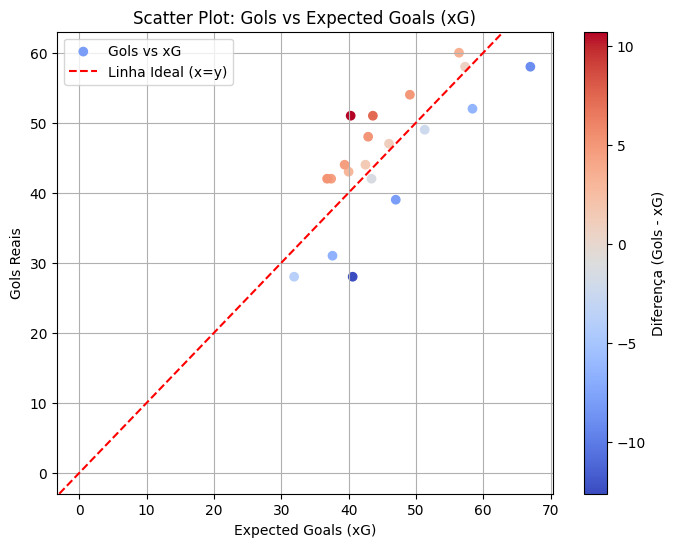

In [35]:
# Calcular a diferença entre Gols e xG
xg_xag_df['Gls_xG_diff'] = xg_xag_df['Gols'] - xg_xag_df['xG']

# Scatter plot com coloração baseada na diferença
plt.figure(figsize=(8, 6))
scatter = plt.scatter(xg_xag_df['xG'], xg_xag_df['Gols'],
                      c=xg_xag_df['Gls_xG_diff'], cmap='coolwarm', label='Gols vs xG')

# Adicionar linha ideal
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Linha Ideal (x=y)')

plt.xlabel('Expected Goals (xG)')
plt.ylabel('Gols Reais')
plt.title('Scatter Plot: Gols vs Expected Goals (xG)')

# Adicionar barra de cores
plt.colorbar(scatter, label='Diferença (Gols - xG)')
plt.legend()
plt.grid(True)
plt.show()


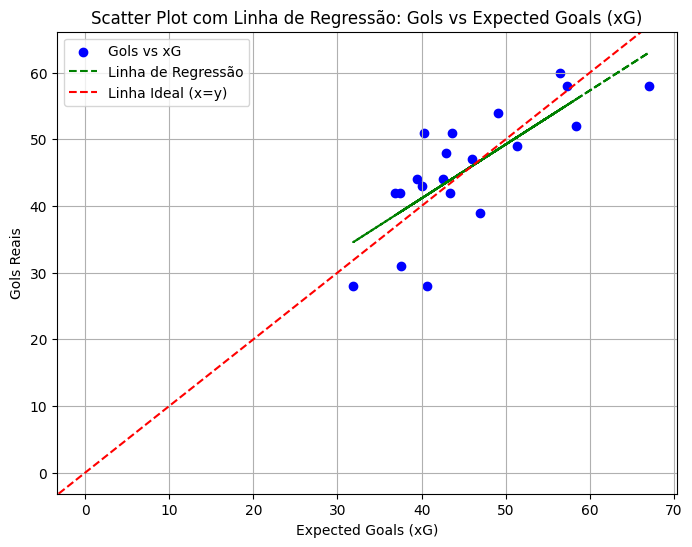

In [36]:
# Ajustar uma linha de regressão linear
m, b = np.polyfit(xg_xag_df['xG'], xg_xag_df['Gols'], 1)

# Plotar scatter e linha de regressão
plt.figure(figsize=(8, 6))
plt.scatter(xg_xag_df['xG'], xg_xag_df['Gols'], color='blue', label='Gols vs xG')
plt.plot(xg_xag_df['xG'], m * xg_xag_df['xG'] + b, color='green', linestyle='--', label='Linha de Regressão')

# Adicionar linha ideal
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='Linha Ideal (x=y)')

plt.xlabel('Expected Goals (xG)')
plt.ylabel('Gols Reais')
plt.title('Scatter Plot com Linha de Regressão: Gols vs Expected Goals (xG)')
plt.legend()
plt.grid(True)
plt.show()


- A linha de regressão verde mostra uma forte relação linear entre o xG e os Gols Reais, o que está de acordo com a correlação de 0.76.

- No entanto, a linha de regressão não é perfeitamente sobreposta à linha ideal, indicando que alguns times podem estar marcando mais ou menos do que o esperado, revelando overperformances e underperformances.